# Bayesian Estimation on Multiple Groups

## Problem Type

The Bayesian estimation model is widely applicable across a number of scenarios. The classical scenario is when we have an experimental design where there is a control vs. a treatment, and we want to know what the difference is between the two. Here, "estimation" is used to estimate the "true" value for the control and the "true" value for the treatment, and the "Bayesian" part refers to the computation of the uncertainty surrounding the parameter. 

Bayesian estimation's advantages over the classical t-test was first described by John Kruschke (2013). 

In this notebook, I provide a concise implementation suitable for two-sample and multi-sample inference, with data that don't necessarily fit Gaussian assumptions.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should indicate, at the minimum:
    - What treatment group the sample belonged to.
    - The measured value.

## Extensions to the model

As of now, the model only samples posterior distributions of measured values. The model, then, may be extended to compute differences in means (sample vs. control) or effect sizes, complete with uncertainty around it. Use `pm.Deterministic(...)` to ensure that those statistics' posterior distributions, i.e. uncertainty, are also computed.

## Reporting summarized findings

Here are examples of how to summarize the findings.

> Treatment group A was greater than control by x units (95% HPD: [`lower`, `upper`]). 

> Treatment group A was higher than control (effect size 95% HPD: [`lower`, `upper`]). 


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pymc4 as pm4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import janitor as jn
from utils import ecdf
from pyprojroot import here

In [3]:
# Read in the data
df = (
    pd.read_csv(here() / "datasets/biofilm.csv")
    .label_encode(columns=["isolate"])  # encode isolate as labels.
    .transform_column("normalized_measurement", np.log, "log_normalized_measurement")
)

# Display a subset of the data.
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement,isolate_enc,log_normalized_measurement
0,1,1,4,0.461,0.317,1,0.687636,0,-0.374496
1,1,2,55,0.346,0.434,1,1.254335,7,0.226606
2,1,3,55,0.356,0.917,1,2.575843,8,0.946177
3,1,4,4,0.603,1.061,1,1.759536,9,0.565050
4,1,5,330,0.444,3.701,1,8.335586,10,2.120534


## Model Specification

We know that the `OD600` and `measurements` columns are all positive-valued, and so the `normalized_measurement` column will also be positive-valued.
There are two ways to handle this situation:

1. We can either choose to directly model the likelihood using a bounded, positive-support-only distribution, or
2. We can model the log-transformation of the `normalized_measurement` column, using an unbounded, infinite-support distribution (e.g. the T-distribution family of distributions, which includes the Gaussian and the Cauchy in there).

The former is ever slightly more convenient to reason about, but the latter lets us use Gaussians, which have some nice properties when sampling.

In [4]:
import tensorflow as tf
import numpy as np

num_isolates = len(set(df["isolate_enc"]))
@pm4.model
def bacteria_model():
    
    mu_mean = yield pm4.Normal("mu_mean", loc=0, scale=1)
    mu = yield pm4.Normal("mu", loc=mu_mean, scale=1, batch_stack=num_isolates)
    mu_bounded = yield pm4.Deterministic("mu_bounded", tf.exp(mu))
    
    # Because we use TFP, tf.gather now replaces the old numpy syntax.
    # the following line is equivalent to:
    #    mu_all = mu[df["isolate_enc"]]
    mu_all = tf.gather(mu, df["isolate_enc"])
    
    sigma = yield pm4.HalfCauchy("sd", scale=1, batch_stack=num_isolates)
    sigma_all = tf.gather(sigma, df["isolate_enc"])
    
    nu = yield pm4.Exponential("nu", rate=1/30.)
    
    like = yield pm4.StudentT("like", loc=mu_all, scale=sigma_all, df=nu, observed=df["log_normalized_measurement"])
    
    # Take the difference against the ATCC strain, which is the control.
    difference = yield pm4.Deterministic("difference", mu_bounded[:-1] - mu_bounded[-1])

## Inference Button!

Now, we hit the Inference Button(tm) and sample from the posterior distribution.

In [5]:
trace = pm4.sample(bacteria_model())

## Diagnostics

Our first diagnostic will be the trace plot.
We expect the trace of the variables that we are most interested in
to be a fuzzy caterpillar.

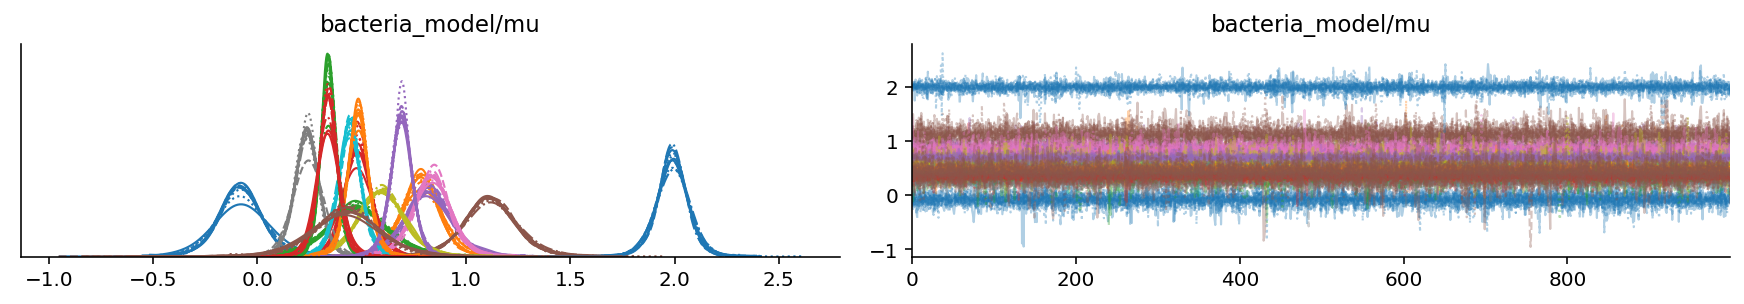

In [6]:
import arviz as az
axes = az.plot_trace(trace, var_names=["bacteria_model/mu"], compact=True)

Looking at the traces, yes, everything looks more or less like a hairy caterpillar. This means that sampling went well, and has converged, thus we have a good MCMC estimator of the posterior distribution.

I need a mapping of isolate to its encoding - will come in handy below.

In [7]:
mapping = dict(zip(df["isolate_enc"], df["isolate"]))
yticklabels = list(reversed([mapping[i] for i in range(len(mapping))]))

Let's now plot the posterior distributions. 
We'll use a ridge plot, as it's both aesthetically pleasing
and informative.

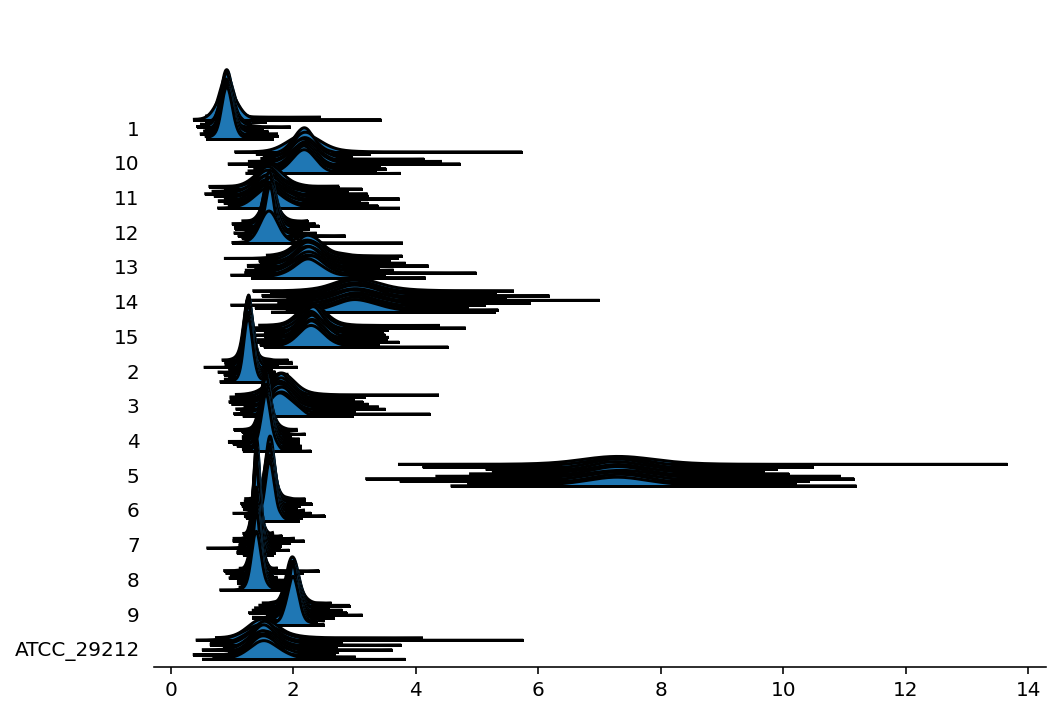

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
axes = az.plot_forest(trace, var_names=["bacteria_model/mu_bounded"], ax=ax, kind="ridgeplot")
axes[0].set_yticklabels(yticklabels);

On the basis of this, we would say that strain 5 was the most different from the other strains.

Let's now look at the differences directly.

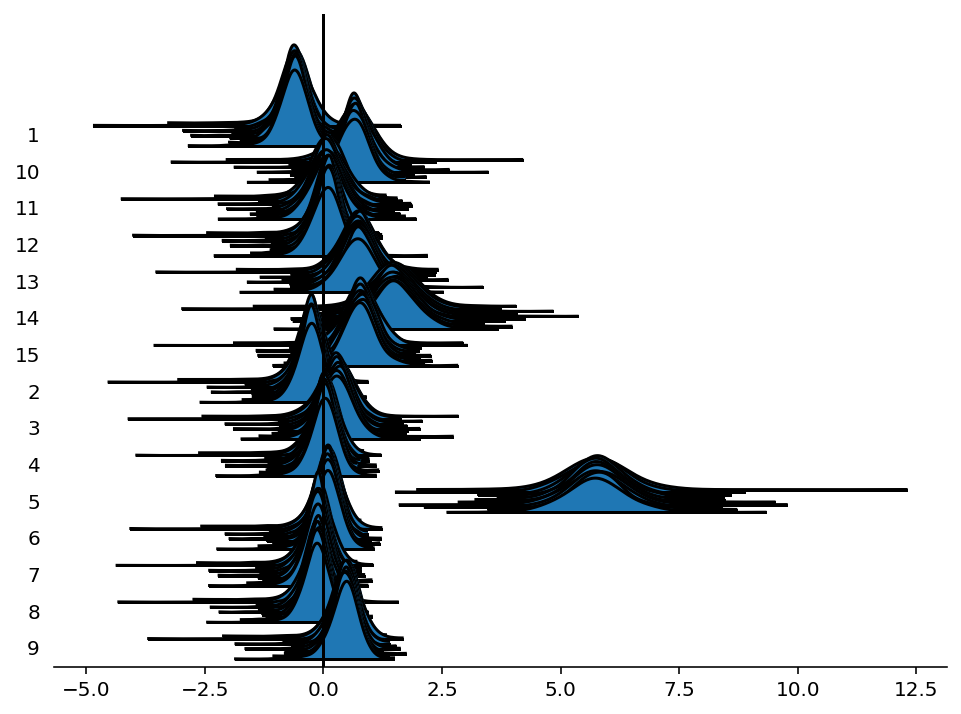

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
axes = az.plot_forest(trace, var_names=["bacteria_model/difference"], ax=ax, kind="ridgeplot")
axes[0].axvline(0, color="black")
axes[0].set_yticklabels(yticklabels[1:]);

If we were in a binary decision-making mode, we would say that isolates 5 was the most "significantly" different from the ATCC strain.

In [10]:
trace_with_posterior = pm4.sample_posterior_predictive(bacteria_model(), trace=trace)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Inconsistent ASTs detected. This is a bug. Cause: 
inconsistent values for field args: [<gast.gast.Name object at 0x7f2a107f0820>, <gast.gast.Name object at 0x7f2a107f05e0>, <gast.gast.Name object at 0x7f2a107f0460>] and []Diff:

*** Original nodes

--- Reparsed nodes

***************

*** 41,55 ****

  | | | ]
  | | | value=Constant:
  | | | | value=None
  | | | | kind=None
  | | FunctionDef:
  | | | name=u"create_converted_entity"
  | | | args=arguments:
! | | | | args=[
  | | | | | Name:
  | | | | | | id=u"ag__"
  | | | | | | ctx=Param()
  | | | | | | annotation=None
  | | | | | | type_comment=None
  | | | | | Name:
  | | | | | | id=u"ag_source_map__"
--- 41,56 ----

  | | | ]
  | | | value=Constant:
  | | | | value=None
  | | | | kind=None
  | | FunctionDef:
  | | | name=u"create_converted_entity"
  | | | args=argumen

In [12]:
trace_with_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:                    (bacteria_model/like_dim_0: 96, chain: 10, draw: 1000)
Coordinates:
  * chain                      (chain) int64 0 1 2 3 4 5 6 7 8 9
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * bacteria_model/like_dim_0  (bacteria_model/like_dim_0) int64 0 1 2 ... 94 95
Data variables:
    bacteria_model/like        (chain, draw, bacteria_model/like_dim_0) float32 -0.10798454 ... 0.7663585
Attributes:
    created_at:     2020-03-21T23:10:11.574949
    arviz_version:  0.7.0

In [13]:
# We want indices for each of the samples.
indices = dict()
for enc, iso in mapping.items():
    idxs = list(df[df["isolate_enc"] == enc].index)
    indices[iso] = idxs
indices

{'1': [0, 16, 32, 48, 64, 80],
 '2': [1, 17, 33, 49, 65, 81],
 '3': [2, 18, 34, 50, 66, 82],
 '4': [3, 19, 35, 51, 67, 83],
 '5': [4, 20, 36, 52, 68, 84],
 '6': [5, 21, 37, 53, 69, 85],
 '7': [6, 22, 38, 54, 70, 86],
 '8': [7, 23, 39, 55, 71, 87],
 '9': [8, 24, 40, 56, 72, 88],
 '10': [9, 25, 41, 57, 73, 89],
 '11': [10, 26, 42, 58, 74, 90],
 '12': [11, 27, 43, 59, 75, 91],
 '13': [12, 28, 44, 60, 76, 92],
 '14': [13, 29, 45, 61, 77, 93],
 '15': [14, 30, 46, 62, 78, 94],
 'ATCC_29212': [15, 31, 47, 63, 79, 95]}

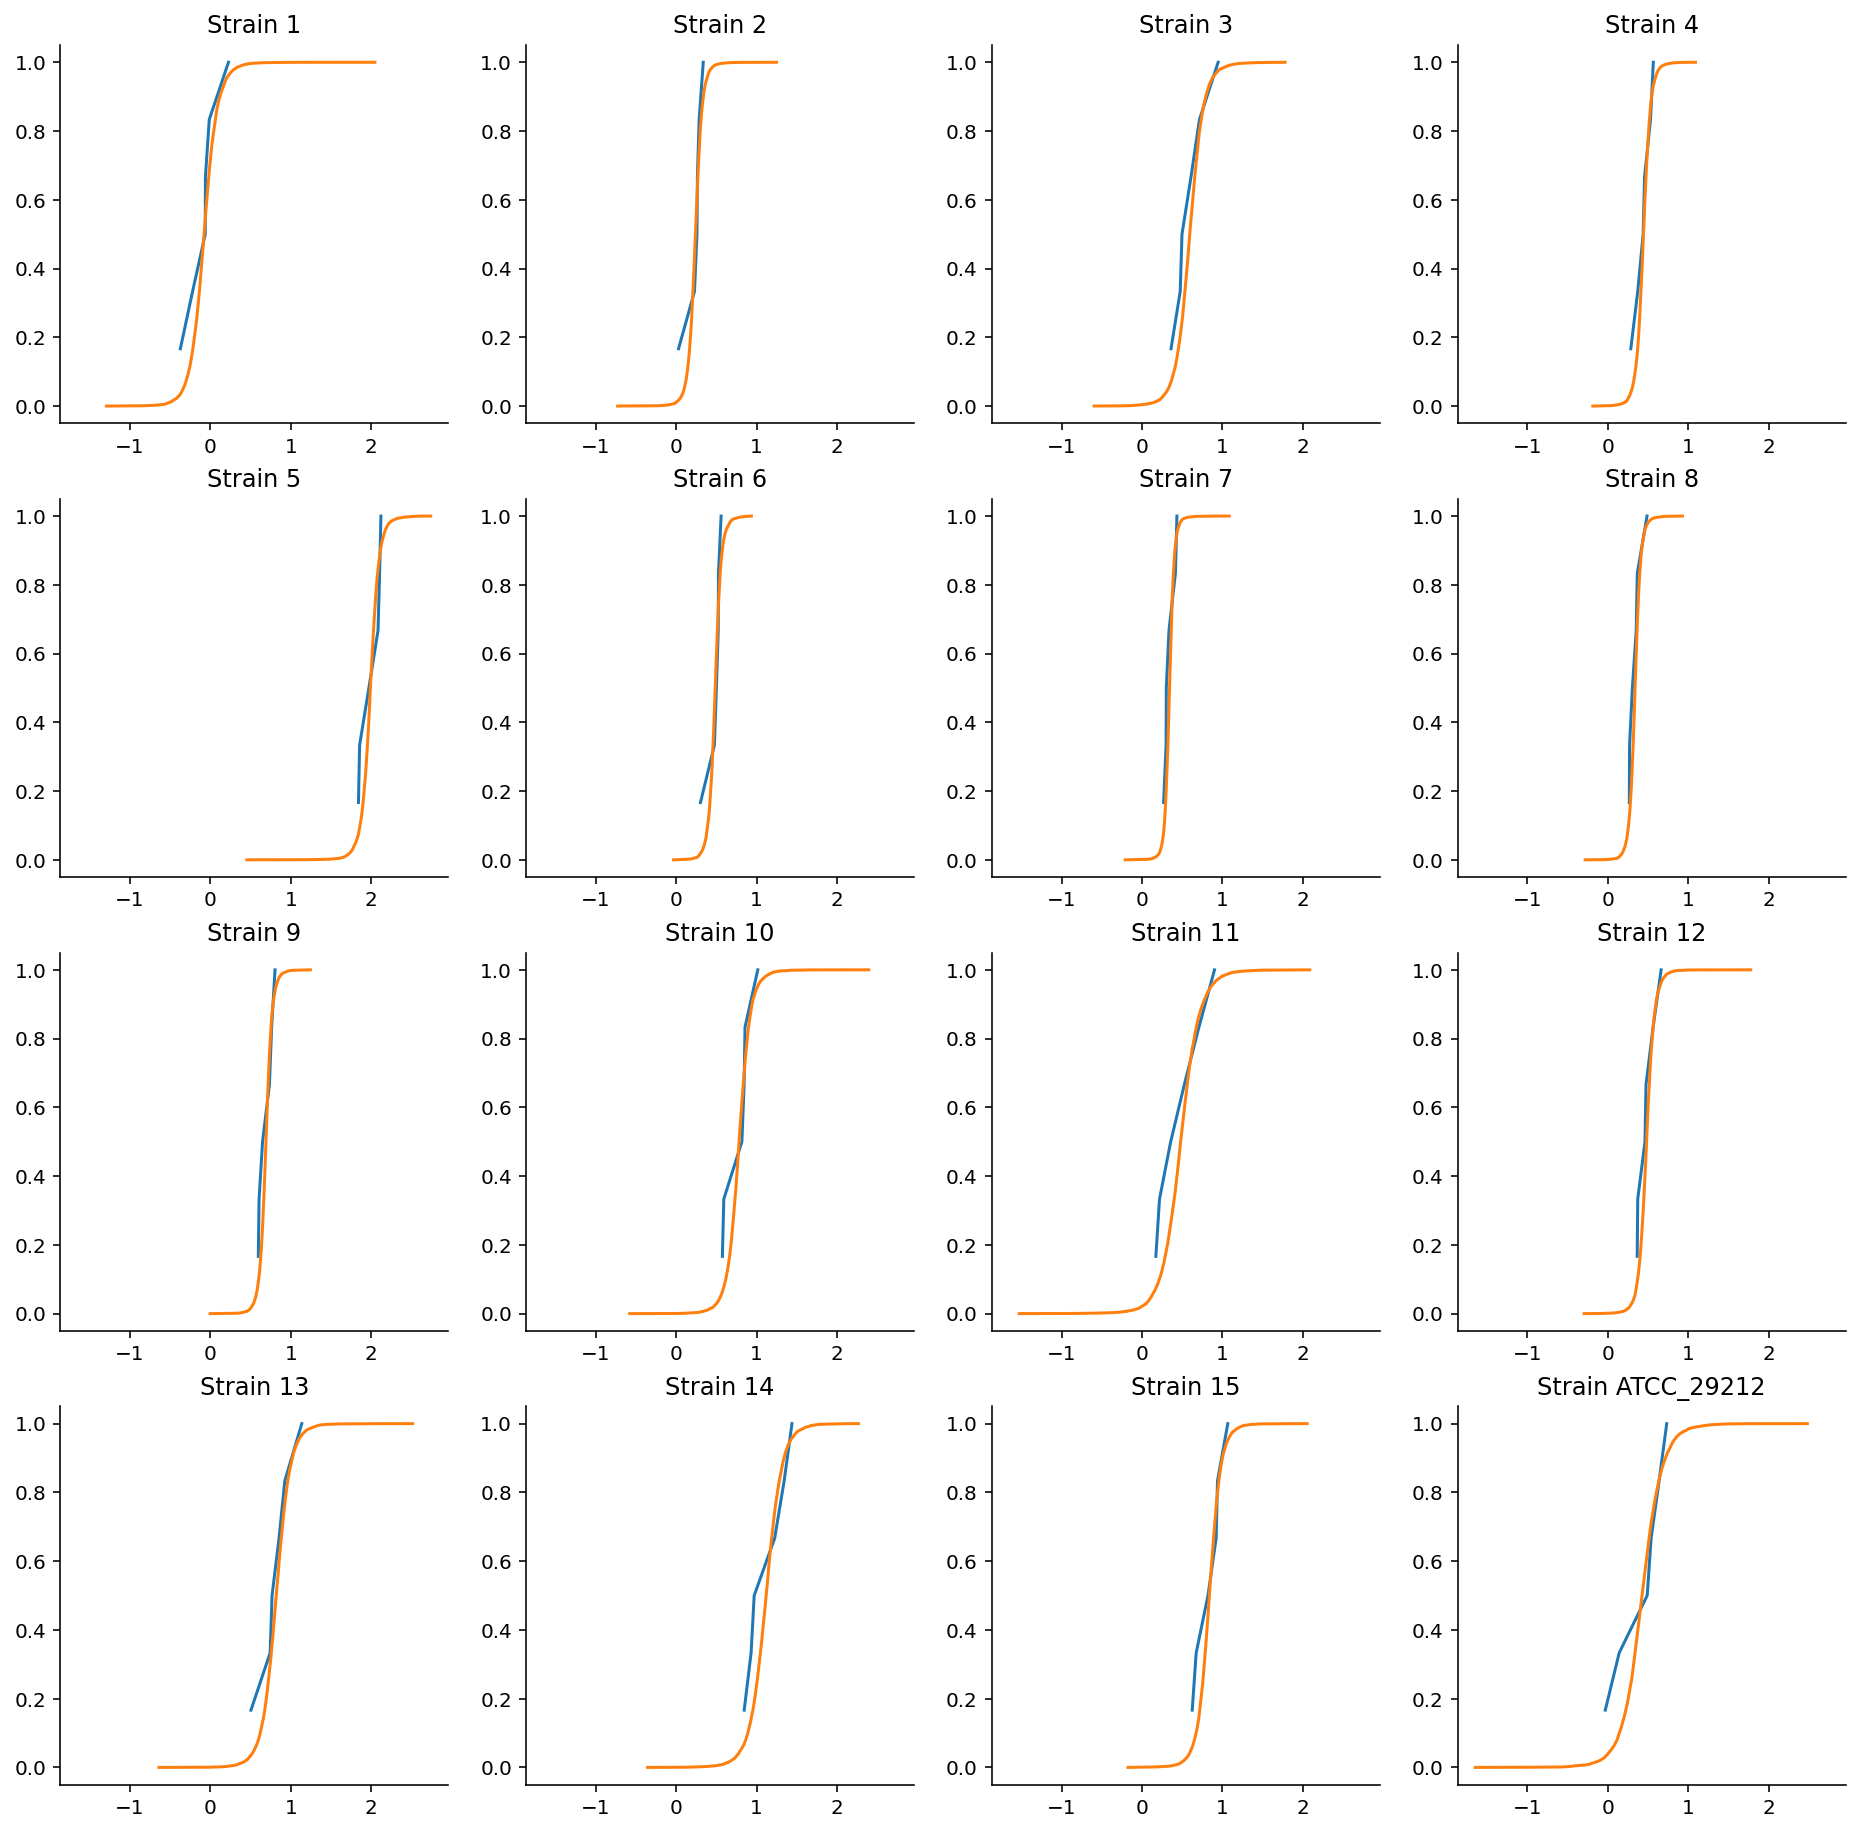

In [14]:
# Make PPC plot for one of the groups.
fig = plt.figure(figsize=(16, 16))
gs = GridSpec(nrows=4, ncols=4)
axes = dict()


for i, (strain, idxs) in enumerate(indices.items()):
    if i > 0:
        ax = fig.add_subplot(gs[i], sharex=axes[0])
    else:
        ax = fig.add_subplot(gs[i])
    x, y = ecdf(df.iloc[idxs]["log_normalized_measurement"])
    ax.plot(x, y, label="data")
    x, y = ecdf(
        trace_with_posterior
        .posterior_predictive["bacteria_model/like"]
        .loc[:, :, idxs]
        .mean(axis=(2))
        .data
        .flatten()
    )
    ax.plot(x, y, label="ppc")
    ax.set_title(f"Strain {strain}")
    axes[i] = ax

The PPC draws clearly have longer tails than do the originals.
I chalk this down to having small number of samples. 
The central tendency is definitely modelled well,
and I don't see wild deviations between the sampled posterior and the measured data.